# AI - Computer Assignment 4

## Machine Learning

In this assignment we are going to test some classification methods from SciKit-learn library in three phases.

First we preprocess the data, then we will test DecisionTree, KNearestNeighbour, and LogisticClassifier and at last we will test some ensemble classification algorithms.

### Precrocessing

The given dataset is data of customers of some shops and we are going to predict if the will return to the shop or not. Dataset has different columns, we have quantity, price, and purchase count as numerical values, Customer ID which is unique, Country which is a categorical column and Date.

At first we extract the countries and target column using following block of code:

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

COLUMN_TARGET = 'Is Back'
COLUMN_COUNTRY = 'Country'
COLUMN_QUANTITY = 'Total Quantity'
COLUMN_PRICE = 'Total Price'
COLUMN_PURCHASE_COUNT = 'Purchase Count'
COLUMN_ID = 'Customer ID'
COLUMN_DATE = 'Date'
COLUMN_MONTH = 'Month'
COLUMN_DOW = 'DoW'

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

DAYS_OF_WEEK = ['Monday', 'Tuesday', 'Wednesday',
                'Thursday', 'Friday', 'Saturday', 'Sunday']

df = pd.read_csv('data.csv')
target = df[COLUMN_TARGET] == 'Yes'

COUNTRIES = df[COLUMN_COUNTRY].unique()



Then we preprocess the date column, month and day of week is extracted from the date:

In [0]:

df[COLUMN_DATE] = pd.to_datetime(df[COLUMN_DATE])
df[COLUMN_MONTH] = df[COLUMN_DATE].dt.month
df[COLUMN_DOW] = df[COLUMN_DATE].dt.dayofweek

Then we will drop unnecessary columns and we will oneHotEncode the Country, Month, and DayOfWeek columns. The problem with OneHotEncoding is that the size of data gets larger as it adds columns for every category with whole data rows.
The scikit-learn ColumnTransformer is used here. Then the information gain is calculated for the final features data frame.


August 0.0
Australia 0.0
Bahrain 0.0
Belgium 0.0
Denmark 0.0
EIRE 0.0
European Community 0.0
Friday 0.0
Iceland 0.0
Italy 0.0
July 0.0
June 0.0
Malta 0.0
March 0.0
Monday 0.0
Netherlands 0.0
Portugal 0.0
September 0.0
Singapore 0.0
Sweden 0.0
Switzerland 0.0
Thursday 0.0
Total Quantity 0.0
United Arab Emirates 0.0
Lithuania 6.917071328582658e-05
Israel 7.857370941133368e-05
Cyprus 0.0001500526235478361
Greece 0.0005957440166743933
Unspecified 0.0006619988256093556
Finland 0.0006630639938132177
Sunday 0.0007415738809037897
Norway 0.0008603610218103075
Austria 0.0014594486730052925
Wednesday 0.0019497841036149044
Czech Republic 0.002281600584342236
Saturday 0.0025572985228947687
Purchase Count 0.0026227947156984843
Channel Islands 0.0028136107253653453
Saudi Arabia 0.003879145554383623
Japan 0.004504018625926864
Poland 0.005523973044514685
Germany 0.0066645159668550225
May 0.006690679884460371
Brazil 0.007078764715907626
United Kingdom 0.007279236662632194
USA 0.008571573714357461
Canada

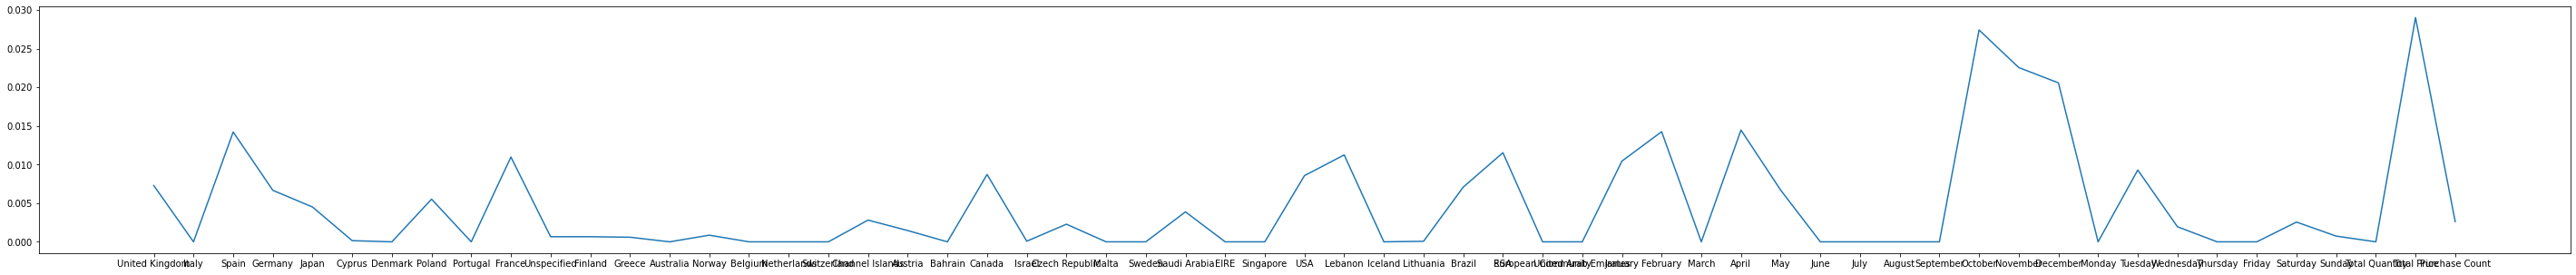

In [0]:
features_df = pd.DataFrame(
    data=ColumnTransformer(
        transformers=[
            (
                'cleaner',
                'drop',
                [
                    COLUMN_ID,
                    COLUMN_DATE,
                    COLUMN_TARGET
                ]
            ),
            (
                'encoder',
                OneHotEncoder(),
                [
                    COLUMN_COUNTRY,
                    COLUMN_MONTH,
                    COLUMN_DOW
                ]
            ),
        ],
        remainder='passthrough',
        sparse_threshold=0,
    ).fit_transform(df),
    columns=[
        *COUNTRIES, *MONTHS, *DAYS_OF_WEEK,
        COLUMN_QUANTITY, COLUMN_PRICE, COLUMN_PURCHASE_COUNT
    ],
).infer_objects()


mutual_info = dict(
    zip(
        list(features_df.columns.values),
        mutual_info_classif(features_df, target)
    )
)

plt.figure(figsize=(50, 5))
plt.plot(
    list(mutual_info.keys()),
    list(mutual_info.values()),
)

for gain, col in sorted([(gain, col) for col, gain in mutual_info.items()]):
    print(col, gain)

Then we split the date to train and test parts:


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_df, target)

And some helper functions + imports:

In [0]:
from sklearn import metrics
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier,
                              VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': metrics.accuracy_score(y_true, y_pred),
        'recall': metrics.recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'precision': metrics.precision_score(y_true, y_pred, average='weighted', zero_division=0),
    }


def test_classifier(Classifier, **kwargs):
    clf = Classifier(**kwargs).fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    return {
        'train': calculate_metrics(y_train, y_train_pred),
        'test': calculate_metrics(y_test, y_test_pred),
    }


def plot_metrics(title, param_title, res):
    fig, (accuracy_ax, recall_ax, precision_ax) = plt.subplots(nrows=1, ncols=3)

    fig.suptitle(title)
    fig.set_figheight(5)
    fig.set_figwidth(25)

    accuracy_ax.plot(
        range(1, 50),
        list(map(lambda x: x['train']['accuracy'], res)),
        list(map(lambda x: x['test']['accuracy'], res)),
    )

    recall_ax.plot(
        range(1, 50),
        list(map(lambda x: x['train']['recall'], res)),
        list(map(lambda x: x['test']['recall'], res)),
    )

    precision_ax.plot(
        range(1, 50),
        list(map(lambda x: x['train']['precision'], res)),
        list(map(lambda x: x['test']['precision'], res)),
    )

    accuracy_ax.legend(['Train', 'Trest'])
    accuracy_ax.set_xlabel(param_title)
    accuracy_ax.set_ylabel('Accuracy')
    recall_ax.set_ylabel('Recall')
    precision_ax.set_ylabel('Precision')


def test_ensemble_classifier(Classifier, **kwargs):
    clf = Classifier(**kwargs).fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    print('train', metrics.classification_report(y_train, y_train_pred))
    print('test', metrics.classification_report(y_test, y_test_pred))


def find_most_accurate_hyper_param(res):
    _, best_param = max(
        [(v, i + 1) for i, v in enumerate(list(map(lambda x: x['test']['accuracy'], res)))])

    return best_param


### Decision Tree
First we will test Decision tree with different depths:


Most accurate Decision Tree Depth: 2
train               precision    recall  f1-score   support

       False       0.67      0.33      0.44      1044
        True       0.75      0.92      0.83      2230

    accuracy                           0.73      3274
   macro avg       0.71      0.63      0.63      3274
weighted avg       0.72      0.73      0.70      3274

test               precision    recall  f1-score   support

       False       0.66      0.32      0.43       336
        True       0.75      0.93      0.83       756

    accuracy                           0.74      1092
   macro avg       0.71      0.62      0.63      1092
weighted avg       0.73      0.74      0.71      1092



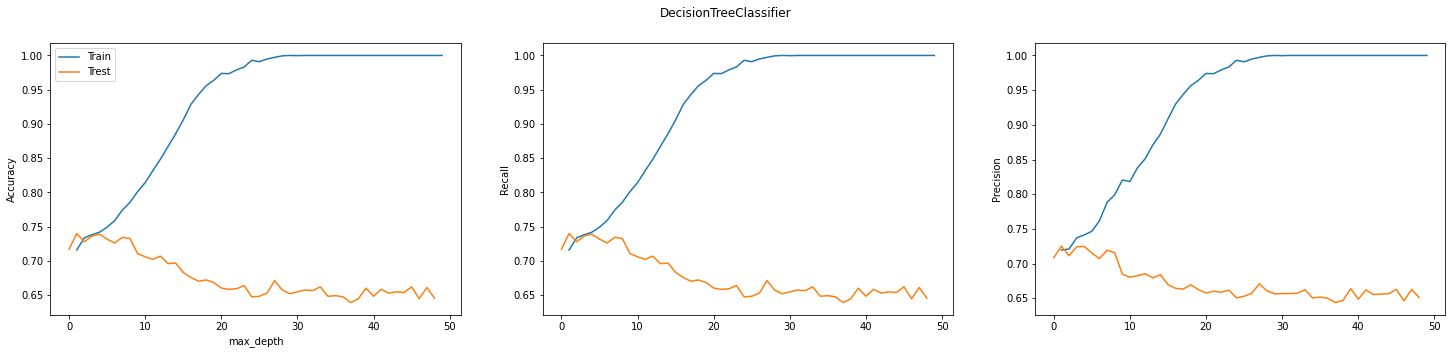

In [0]:
dt_res = [
    test_classifier(DecisionTreeClassifier, max_depth=i)
    for i in range(1, 50)
]
plot_metrics(
    DecisionTreeClassifier.__name__,
    'max_depth',
    dt_res,
)

most_accurate_depth = find_most_accurate_hyper_param(dt_res)
print("Most accurate Decision Tree Depth:", most_accurate_depth)
test_ensemble_classifier(DecisionTreeClassifier, max_depth=most_accurate_depth)

As we can see from the plots, in higher depths the train data overfits because it will learn all the features in the training set and will overfit at classification.

### K Nearest Neighbor

Now lets test KNN with different number of neighbors:

Most accurate KNN Neighbors: 49
train               precision    recall  f1-score   support

       False       0.25      0.00      0.00      1044
        True       0.68      1.00      0.81      2230

    accuracy                           0.68      3274
   macro avg       0.47      0.50      0.41      3274
weighted avg       0.54      0.68      0.55      3274

test               precision    recall  f1-score   support

       False       0.00      0.00      0.00       336
        True       0.69      1.00      0.82       756

    accuracy                           0.69      1092
   macro avg       0.35      0.50      0.41      1092
weighted avg       0.48      0.69      0.57      1092



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


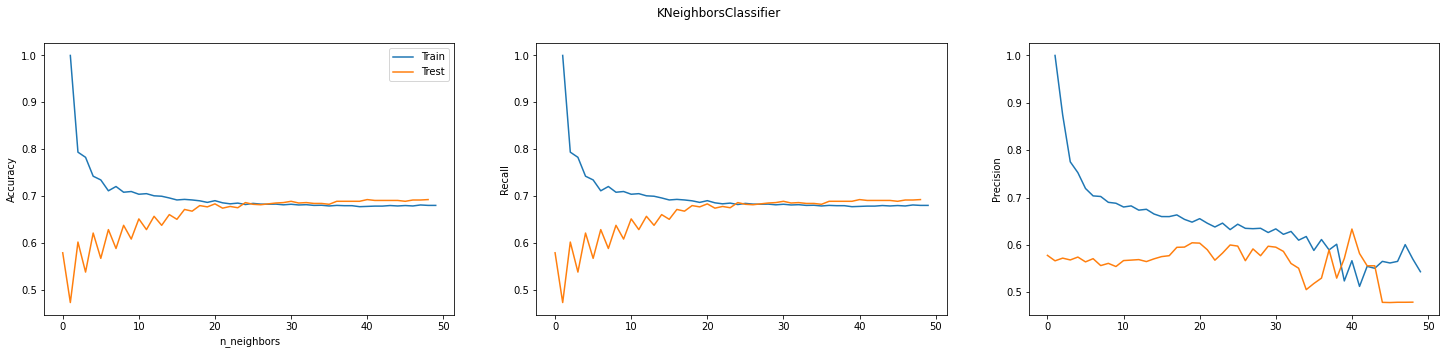

In [0]:
knn_res = [
    test_classifier(KNeighborsClassifier, n_neighbors=i)
    for i in range(1, 50)
]
plot_metrics(
    KNeighborsClassifier.__name__,
    'n_neighbors',
    knn_res,
)

most_accurate_n_neighbors = find_most_accurate_hyper_param(knn_res)
print("Most accurate KNN Neighbors:", most_accurate_n_neighbors)
test_ensemble_classifier(KNeighborsClassifier,
                         n_neighbors=most_accurate_n_neighbors)


We can see that in very low neighbors the train data overfits, it also happens when we check a lot of neighbors as it may reach irrelevant to find that number of neighbors. Also for odd neighbors we have better result as it as a tie-breaker at the end.

### Logistic Regression

Now we will test logistic regression classifier:

In [0]:
test_ensemble_classifier(LogisticRegression, max_iter=1000)

train               precision    recall  f1-score   support

       False       0.68      0.33      0.44      1044
        True       0.75      0.93      0.83      2230

    accuracy                           0.74      3274
   macro avg       0.71      0.63      0.64      3274
weighted avg       0.73      0.74      0.70      3274

test               precision    recall  f1-score   support

       False       0.69      0.32      0.44       336
        True       0.76      0.94      0.84       756

    accuracy                           0.75      1092
   macro avg       0.72      0.63      0.64      1092
weighted avg       0.74      0.75      0.71      1092



### Ensemble Classifiers

#### Bagging

This classifier will make n training data set and the estimators run in parallel and at last the average is considered as the result.

First we try bagging classifier with desicion tree and KNN with best hyper params from last part: 

In [0]:
test_ensemble_classifier(
    BaggingClassifier,
    base_estimator=DecisionTreeClassifier(max_depth=most_accurate_depth),
    max_samples=0.5,
    max_features=0.5,
    n_estimators=5,
)

train               precision    recall  f1-score   support

       False       0.62      0.15      0.24      1044
        True       0.71      0.96      0.81      2230

    accuracy                           0.70      3274
   macro avg       0.66      0.55      0.52      3274
weighted avg       0.68      0.70      0.63      3274

test               precision    recall  f1-score   support

       False       0.66      0.16      0.26       336
        True       0.72      0.96      0.82       756

    accuracy                           0.72      1092
   macro avg       0.69      0.56      0.54      1092
weighted avg       0.70      0.72      0.65      1092



In [0]:
test_ensemble_classifier(
    BaggingClassifier,
    base_estimator=KNeighborsClassifier(n_neighbors=most_accurate_n_neighbors),
    max_samples=0.5,
    max_features=0.5,
    n_estimators=5,
)

train               precision    recall  f1-score   support

       False       0.00      0.00      0.00      1044
        True       0.68      1.00      0.81      2230

    accuracy                           0.68      3274
   macro avg       0.34      0.50      0.41      3274
weighted avg       0.46      0.68      0.55      3274

test               precision    recall  f1-score   support

       False       0.00      0.00      0.00       336
        True       0.69      1.00      0.82       756

    accuracy                           0.69      1092
   macro avg       0.35      0.50      0.41      1092
weighted avg       0.48      0.69      0.57      1092



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The purpose of Bagging algorithm is to reduce overfit but as the dataset here is small the results are the same.

#### Random Forest

It is just bagging algorithm for decision tree.

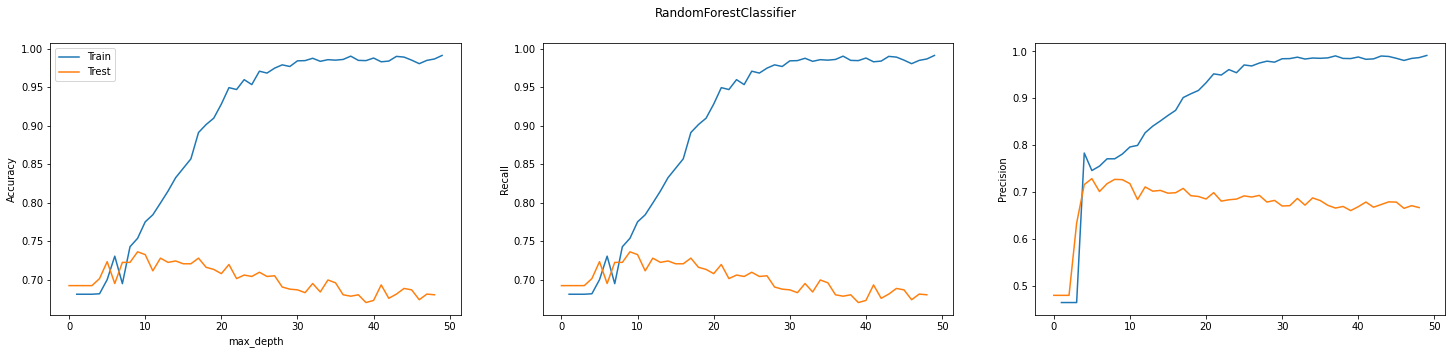

In [15]:
plot_metrics(
    RandomForestClassifier.__name__,
    'max_depth',
    [
        test_classifier(
            RandomForestClassifier,
            max_depth=i,
            n_estimators=10,
            max_features=5,
        )
        for i in range(1, 50)
    ]
)

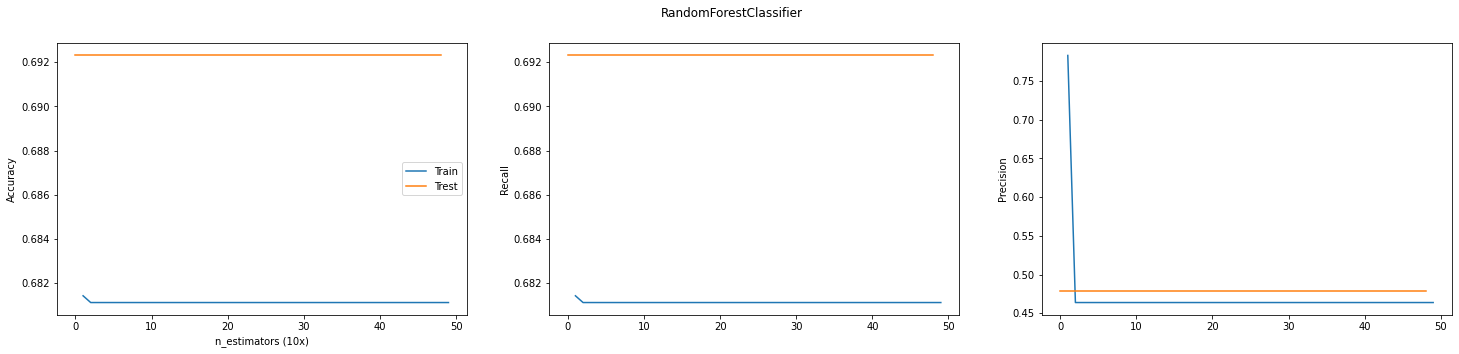

In [21]:
plot_metrics(
    RandomForestClassifier.__name__,
    'n_estimators (10x)',
    [
        test_classifier(
            RandomForestClassifier,
            max_depth=most_accurate_depth,
            n_estimators=i * 10,
            max_features=5,
        )
        for i in range(1, 50)
    ]
)


In [0]:
test_ensemble_classifier(
    RandomForestClassifier,
    max_depth=most_accurate_depth,
    n_estimators=10,
    max_features=5,
)

train               precision    recall  f1-score   support

       False       0.73      0.17      0.28      1044
        True       0.71      0.97      0.82      2230

    accuracy                           0.72      3274
   macro avg       0.72      0.57      0.55      3274
weighted avg       0.72      0.72      0.65      3274

test               precision    recall  f1-score   support

       False       0.68      0.15      0.24       336
        True       0.72      0.97      0.83       756

    accuracy                           0.72      1092
   macro avg       0.70      0.56      0.54      1092
weighted avg       0.71      0.72      0.65      1092



#### Voting classifier

The last one to try is voting classifier, in this kind of ensemble classifier there are a list of estimators and then the result is chosen based on results of each estimator, the most voted result:

In [12]:
test_ensemble_classifier(
    VotingClassifier,
    estimators=[
        (
            DecisionTreeClassifier.__name__,
            DecisionTreeClassifier(max_depth=most_accurate_depth),
        ),
        (
            KNeighborsClassifier.__name__,
            KNeighborsClassifier(n_neighbors=most_accurate_n_neighbors),
        ),
        (
            LogisticRegression.__name__,
            LogisticRegression(max_iter=1000),
        ),
    ],
    voting='hard',
)

train               precision    recall  f1-score   support

       False       0.68      0.32      0.43      1044
        True       0.74      0.93      0.83      2230

    accuracy                           0.73      3274
   macro avg       0.71      0.62      0.63      3274
weighted avg       0.72      0.73      0.70      3274

test               precision    recall  f1-score   support

       False       0.68      0.30      0.42       336
        True       0.75      0.94      0.83       756

    accuracy                           0.74      1092
   macro avg       0.72      0.62      0.63      1092
weighted avg       0.73      0.74      0.71      1092



As we can see metrics don't get better because all the classifiers are almost the same, let's see:

In [14]:

best_dt_res = DecisionTreeClassifier(
    max_depth=most_accurate_depth).fit(X_train, y_train).predict(X_test)

best_knn_res = KNeighborsClassifier(
    n_neighbors=most_accurate_n_neighbors).fit(X_train, y_train).predict(X_test)

best_lr_res = LogisticRegression(
    max_iter=1000).fit(X_train, y_train).predict(X_test)

dt_knn = 0
dt_lr = 0
knn_lr = 0
dt_knn_lr = 0

for i in range(len(best_dt_res)):
    dt_knn += (best_dt_res[i] == best_knn_res[i])
    dt_lr += (best_dt_res[i] == best_lr_res[i])
    knn_lr += (best_knn_res[i] == best_lr_res[i])
    dt_knn_lr += (best_dt_res[i] == best_knn_res[i]
                  and best_knn_res[i] == best_lr_res[i])

print('len', len(best_dt_res))
print('dt_knn', dt_knn)
print('dt_lr', dt_lr)
print('knn_lr', knn_lr)
print('dt_knn_lr', dt_knn_lr)



len 1092
dt_knn 932
dt_lr 1075
knn_lr 937
dt_knn_lr 926


As we can see above a lot results are the same between different classifiers, as they are almost the same.